In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)


In [2]:
x_train = pd.read_csv("X_train_origin.csv")
x_valid = pd.read_csv("X_valid_origin.csv")

y_train = pd.read_csv("y_train_origin.csv")
y_valid = pd.read_csv("y_valid_origin.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
    'Valor_prestamo',  'cuentas_otros_x_tiempo_empleo', 
    'cuentas_otros_x_impulsividad', 'cuentas_otros_x_confianza_entre_tiempo_empleo', 
    'valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo', 'valor_prestamo_x_autocontrol',
    'valor_prestamo_x_autocontrol_entre_cuentas_otros', 'valor_prestamo_x_impulsividad_entre_cuentas_otros', 
    'valor_prestamo_x_impulsividad_entre_tiempo_empleo', 'valor_prestamo_x_confianza_entre_tiempo_empleo', 
    'saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros', 'saldo_cuenta_x_autocontrol', 
    'saldo_cuenta_x_impulsividad_entre_tiempo_empleo', 'tiempo_empleo_x_impulsividad_entre_cuentas_otros',
    'autocontrol_x_impulsividad_entre_tiempo_empleo'
] 

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Valor_prestamo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,tiempo_empleo_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,target
Valor_prestamo,1.00000,-0.00051,0.00040,-0.00238,0.05733,0.88246,0.37615,0.37539,0.32606,0.32882,-0.00142,-0.00162,-0.00423,0.00226,0.00002,-0.00211
cuentas_otros_x_tiempo_empleo,-0.00051,1.00000,0.59758,0.13174,-0.02555,-0.00164,0.17496,0.17554,-0.15275,-0.15225,0.09047,0.00459,-0.02171,0.54028,-0.16921,0.00510
cuentas_otros_x_impulsividad,0.00040,0.59758,1.00000,0.52958,-0.00098,0.00160,0.26471,0.31187,0.03078,0.00037,0.03053,0.00252,0.00081,0.21949,0.03561,0.00329
cuentas_otros_x_confianza_entre_tiempo_empleo,-0.00238,0.13174,0.52958,1.00000,0.08104,0.00195,0.15530,0.15473,0.47580,0.51234,-0.00778,-0.00278,0.06256,-0.03915,0.52770,0.00129
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.05733,-0.02555,-0.00098,0.08104,1.00000,0.05448,0.02383,0.02294,0.16195,0.16318,0.22281,0.58772,0.72080,-0.02660,0.13969,-0.00590
valor_prestamo_x_autocontrol,0.88246,-0.00164,0.00160,0.00195,0.05448,1.00000,0.42797,0.33379,0.29401,0.29600,-0.00398,0.01504,-0.00052,0.00278,0.08239,-0.00425
valor_prestamo_x_autocontrol_entre_cuentas_otros,0.37615,0.17496,0.26471,0.15530,0.02383,0.42797,1.00000,0.92813,0.12909,0.12967,0.07059,0.00513,0.00108,0.48482,0.03920,-0.00364
valor_prestamo_x_impulsividad_entre_cuentas_otros,0.37539,0.17554,0.31187,0.15473,0.02294,0.33379,0.92813,1.00000,0.16302,0.12878,0.07421,0.00026,0.00448,0.52919,0.03928,-0.00329
valor_prestamo_x_impulsividad_entre_tiempo_empleo,0.32606,-0.15275,0.03078,0.47580,0.16195,0.29401,0.12909,0.16302,1.00000,0.93516,-0.02720,-0.00152,0.10518,-0.14544,0.84770,0.00110
valor_prestamo_x_confianza_entre_tiempo_empleo,0.32882,-0.15225,0.00037,0.51234,0.16318,0.29600,0.12967,0.12878,0.93516,1.00000,-0.02754,-0.00184,0.09986,-0.15976,0.78322,0.00144


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
saldo_cuenta_x_autocontrol,0.00699
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.00590
saldo_cuenta_x_impulsividad_entre_tiempo_empleo,0.00516
cuentas_otros_x_tiempo_empleo,0.00510
valor_prestamo_x_autocontrol,0.00425
saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,0.00421
valor_prestamo_x_autocontrol_entre_cuentas_otros,0.00364
cuentas_otros_x_impulsividad,0.00329
valor_prestamo_x_impulsividad_entre_cuentas_otros,0.00329


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Valor_prestamo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,tiempo_empleo_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,target
Valor_prestamo,1.00000,-0.00015,-0.00016,-0.00118,0.32616,0.79440,0.39945,0.39820,0.41385,0.41424,-0.00076,0.00411,-0.00181,-0.00152,-0.00179,-0.00436
cuentas_otros_x_tiempo_empleo,-0.00015,1.00000,0.71344,0.73739,0.16492,0.00026,0.44557,0.44485,0.06563,0.06592,0.82805,-0.00007,0.19994,0.87108,0.07699,0.00283
cuentas_otros_x_impulsividad,-0.00016,0.71344,1.00000,0.81072,0.00184,0.00125,0.43664,0.47820,0.03252,0.00359,0.47331,0.00080,0.01303,0.44898,0.03869,0.00278
cuentas_otros_x_confianza_entre_tiempo_empleo,-0.00118,0.73739,0.81072,1.00000,0.19101,0.00172,0.52708,0.52650,0.28737,0.30004,0.67102,-0.00133,0.23522,0.58438,0.35639,0.00113
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.32616,0.16492,0.00184,0.19101,1.00000,0.31439,0.29107,0.29118,0.71293,0.71109,0.47891,0.52823,0.80068,0.27981,0.47151,-0.00360
valor_prestamo_x_autocontrol,0.79440,0.00026,0.00125,0.00172,0.31439,1.00000,0.45058,0.37145,0.38321,0.38301,0.00171,0.05746,0.00031,0.00243,0.10120,-0.00618
valor_prestamo_x_autocontrol_entre_cuentas_otros,0.39945,0.44557,0.43664,0.52708,0.29107,0.45058,1.00000,0.96824,0.30875,0.30967,0.43614,0.01485,0.00174,0.47309,0.02614,-0.00255
valor_prestamo_x_impulsividad_entre_cuentas_otros,0.39820,0.44485,0.47820,0.52650,0.29118,0.37145,0.96824,1.00000,0.32919,0.30907,0.43602,0.00215,0.01052,0.48645,0.02568,-0.00238
valor_prestamo_x_impulsividad_entre_tiempo_empleo,0.41385,0.06563,0.03252,0.28737,0.71293,0.38321,0.30875,0.32919,1.00000,0.96738,0.27533,0.00259,0.48428,0.19940,0.76517,0.00009
valor_prestamo_x_confianza_entre_tiempo_empleo,0.41424,0.06592,0.00359,0.30004,0.71109,0.38301,0.30967,0.30907,0.96738,1.00000,0.27507,-0.00003,0.47012,0.18780,0.72938,0.00034


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
saldo_cuenta_x_autocontrol,0.00815
valor_prestamo_x_autocontrol,0.00618
Valor_prestamo,0.00436
saldo_cuenta_x_impulsividad_entre_tiempo_empleo,0.00426
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.00360
cuentas_otros_x_tiempo_empleo,0.00283
cuentas_otros_x_impulsividad,0.00278
valor_prestamo_x_autocontrol_entre_cuentas_otros,0.00255
valor_prestamo_x_impulsividad_entre_cuentas_otros,0.00238


In [9]:
del x_train['target']

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = RepeatedStratifiedKFold(
    n_splits=3, 
    n_repeats=2,
    random_state=SEED
)

param_grid_arbol = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],             
    'min_samples_split': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'max_features': [0.8, 0.85, 0.9, 0.95, 1.0],
    'random_state': [SEED],
    'class_weight': ['balanced', None],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}
model_arbol = DecisionTreeClassifier(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=2,
    n_iter=1000,
    refit=True
)

In [11]:
%%time
grid_arbol.fit(
    x_train[cols_aporte],
    y_train,
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 6 folds for each of 1000 candidates, totalling 6000 fits
score:  0.5038411894672038
Wall time: 9min 28s


In [12]:
best_params_arbol

{'splitter': 'random',
 'random_state': 29082013,
 'min_samples_split': 0.05,
 'max_features': 0.85,
 'max_depth': 7,
 'criterion': 'entropy',
 'class_weight': None,
 'ccp_alpha': 0}

In [13]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict(x_train[cols_aporte])
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict(x_valid[cols_aporte])
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [14]:
pd.Series(y_pred_class_2_train).value_counts()

0    51117
1        3
dtype: int64

In [15]:
pd.Series(y_pred_class_2_valid).value_counts()

0    12780
1        1
dtype: int64

<AxesSubplot:>

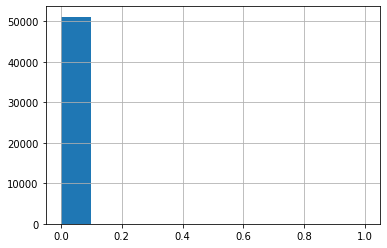

In [16]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

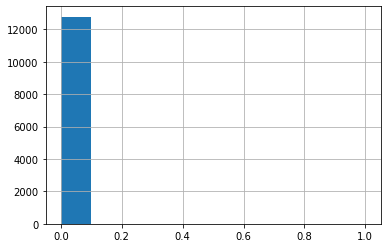

In [17]:
pd.Series(y_pred_prob_2_valid).hist()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.500
GINI: 0.000
///////////////////////// VALIDATION
AUC: 0.500
GINI: -0.000


In [37]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % accuracy_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00041574
EFECTIVIDAD: 1.00000000
F1 SCORE   : 0.00083114
F1 SCORE   : 0.85890063
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
F1 SCORE   : 0.85877474


#### >>> RECALL

In [20]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -0.0004157427937915743
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

In [21]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.11725487017104697

In [22]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [23]:
y_train.value_counts()

Incumplimiento
0                 43904
1                  7216
dtype: int64

In [24]:
pd.Series(y_pred_class_train_2_rec).value_counts()

0    51117
1        3
dtype: int64

In [25]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

0    12780
1        1
dtype: int64

In [26]:
y_valid.value_counts()

Incumplimiento
0                 10977
1                  1804
dtype: int64

In [27]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 0.00041574
EFECTIVIDAD: 1.00000000
F1 SCORE   : 0.00083114
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


#### >>> EFECTIVIDAD

In [28]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

#### >>> AUC

In [33]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_valid, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_valid])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.49995445021408397
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

In [34]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.11725487017104697

In [35]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [36]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.00041574
EFECTIVIDAD: 1.00000000
F1 SCORE   : 0.00083114
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
